In [1]:
try: 
    import torch
except:
    print("PyTorch not found. Please install it.")

In [1]:
from datetime import datetime
from ecallisto_ng.plotting.plotting import plot_spectogram_mpl, fill_missing_timesteps_with_nan
from ecallisto_ng.combine_antennas.combine import preprocess_data, sync_spectrograms, match_spectrograms
import pandas as pd
import numpy as np
import pandas as pd
import torch
from ecallisto_ng.data_fetching.get_data import get_data
import torch.nn.functional as F
from ecallisto_ng.plotting.utils import (
    fill_missing_timesteps_with_nan,
)
from glob import glob
import torch
import pandas as pd
import os
from ecallisto_ng.data_fetching.get_information import get_tables

In [2]:
start_datetime = datetime(2023, 9, 28, 9, 00, 0).strftime("%Y-%m-%d %H:%M:%S")
end_datetime = datetime(2023, 9, 28, 9, 10, 0).strftime("%Y-%m-%d %H:%M:%S")
data_folder = 'data_virtual_antenna'
filter = None
max_download_duration = 60

In [3]:
# Download all available data
for table in get_tables():
    if table in ['swiss_heiterswil_59', 'spain_siguenza_02', 'roswell_nm_57', 'southafrica_sansa_01', 'norway_ny_aalesund_01']: # Some tables take forever to download
        continue
    fast_api_parameter =  {
        "instrument_name": table,
        "start_datetime": start_datetime,
        "end_datetime": end_datetime,
        "timebucket": "0.25s",
        "agg_function": "MAX",
    }
    try:
        df = get_data(**fast_api_parameter)
        file_name = f"{data_folder}/{table}_{start_datetime}_{end_datetime}.parquet"
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        df.to_parquet(file_name)
    except Exception as e:
        print(e)
        continue

No data available for {'instrument_name': 'thailand_pathumthani_01', 'start_datetime': '2023-09-28 09:00:00', 'end_datetime': '2023-09-28 09:10:00', 'timebucket': '0.25s', 'agg_function': 'MAX'}
No data available for {'instrument_name': 'mexico_fcfm_uanl_01', 'start_datetime': '2023-09-28 09:00:00', 'end_datetime': '2023-09-28 09:10:00', 'timebucket': '0.25s', 'agg_function': 'MAX'}
No data available for {'instrument_name': 'nasa_02', 'start_datetime': '2023-09-28 09:00:00', 'end_datetime': '2023-09-28 09:10:00', 'timebucket': '0.25s', 'agg_function': 'MAX'}
No data available for {'instrument_name': 'xcountry_62', 'start_datetime': '2023-09-28 09:00:00', 'end_datetime': '2023-09-28 09:10:00', 'timebucket': '0.25s', 'agg_function': 'MAX'}
No data available for {'instrument_name': 'japan_ibaraki_59', 'start_datetime': '2023-09-28 09:00:00', 'end_datetime': '2023-09-28 09:10:00', 'timebucket': '0.25s', 'agg_function': 'MAX'}
No data available for {'instrument_name': 'mrt2_02', 'start_date

In [4]:
# Gef file paths of all downloaded data
files = glob(f"{data_folder}/*.parquet")

In [5]:
# Read in all data
datas = [pd.read_parquet(file) for file in files] 

In [6]:
# Preprocess data
data_processed = preprocess_data(datas)

/home/kenfus/ecallisto_ng/src/ecallisto_ng/plotting/plotting.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=fig_size)


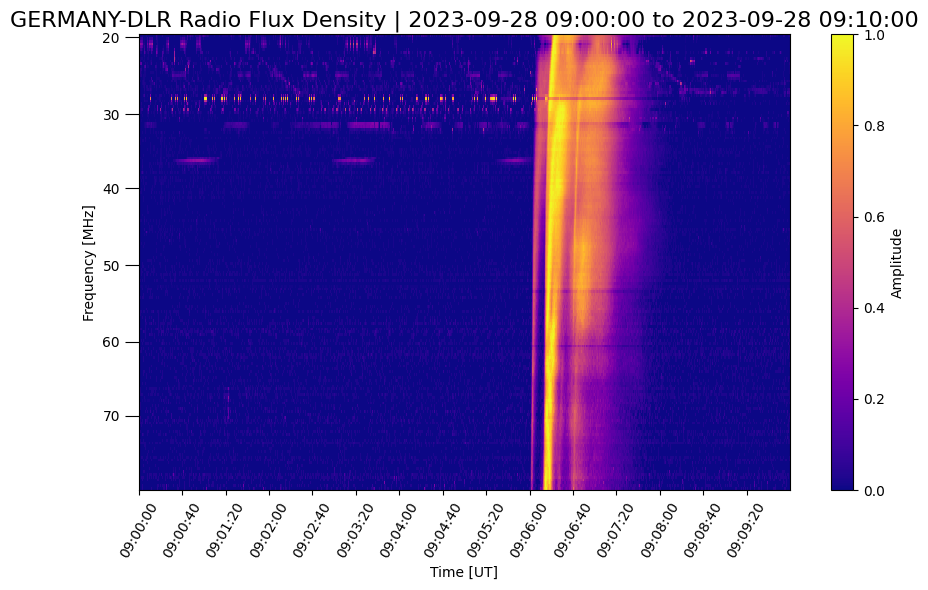

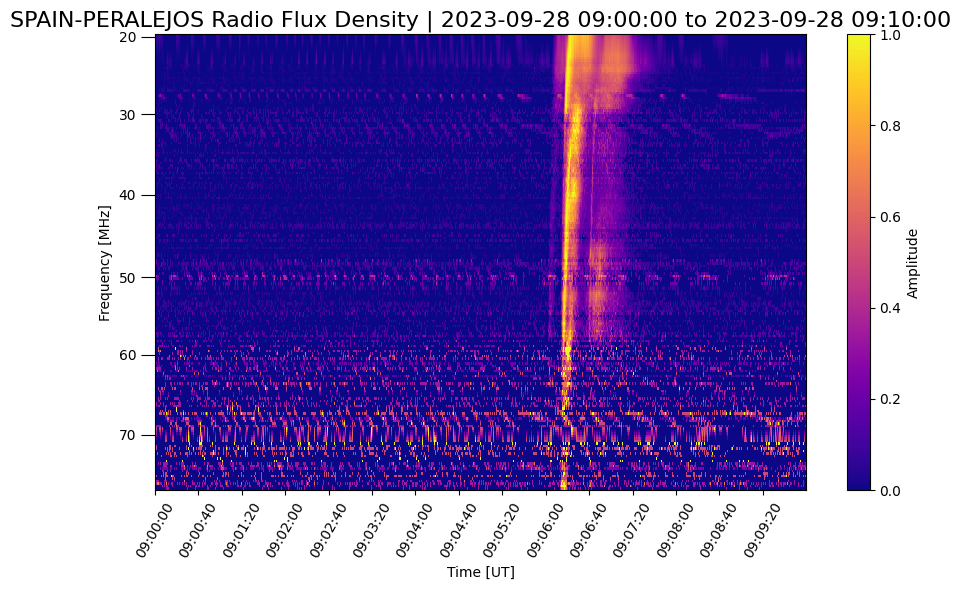

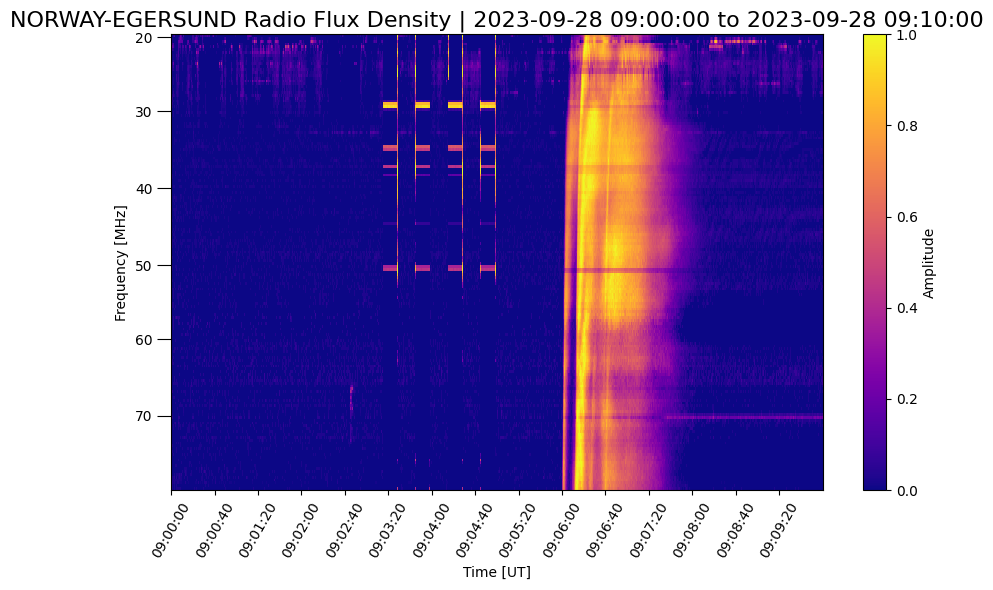

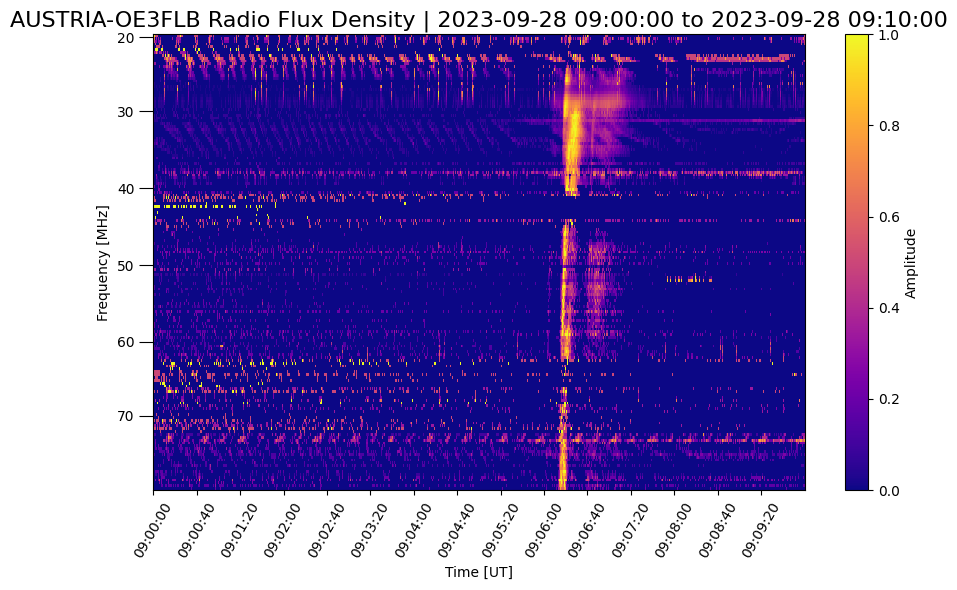

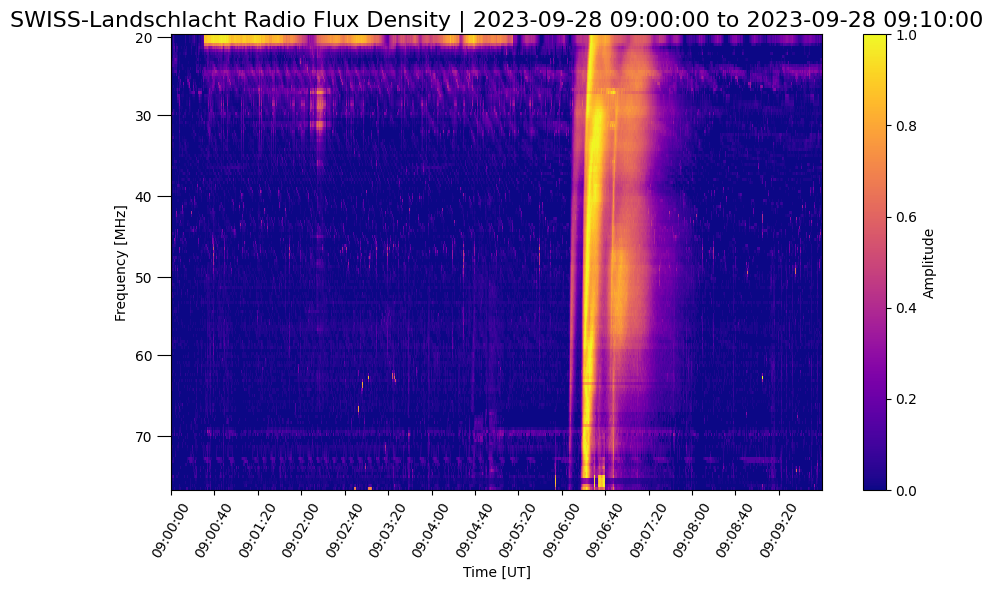

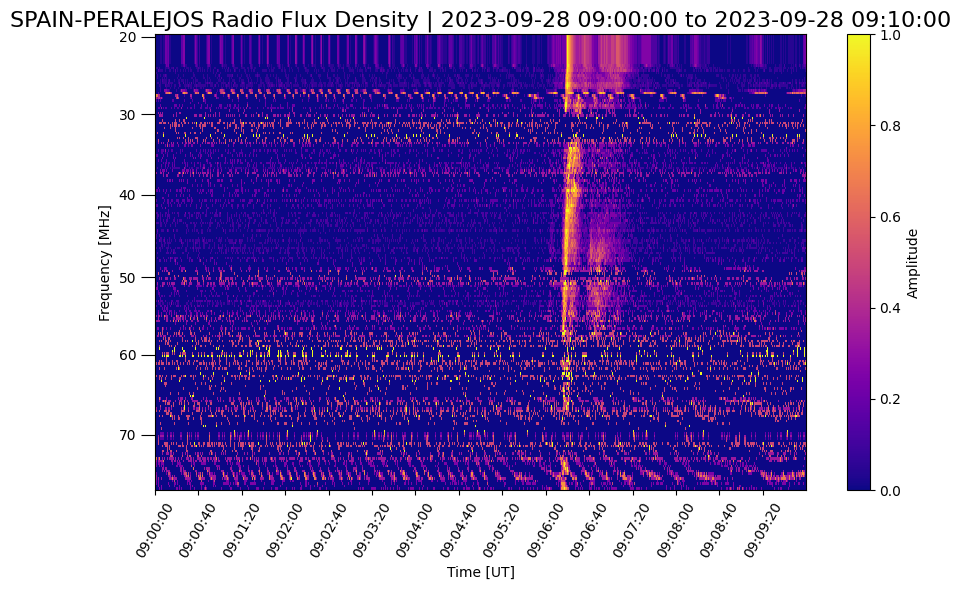

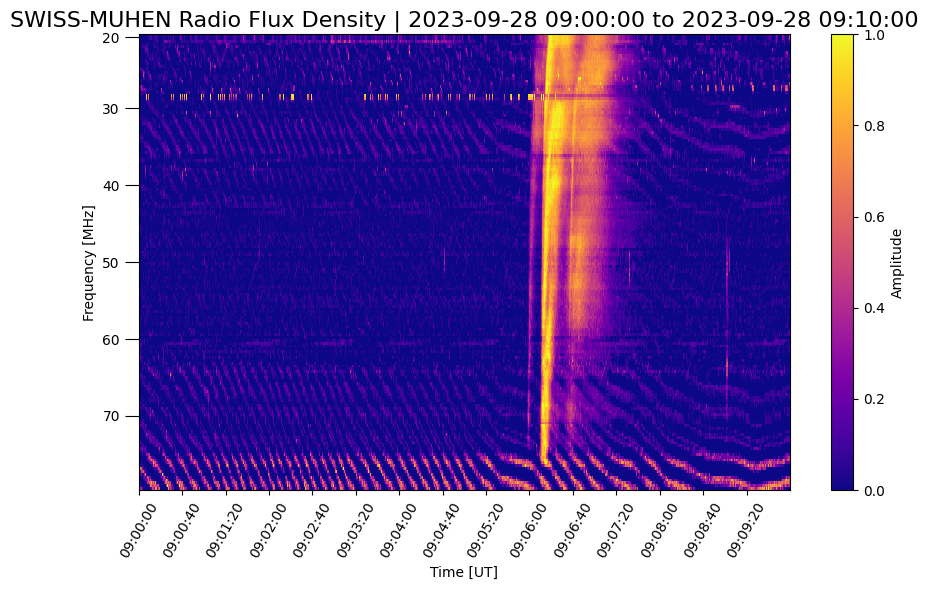

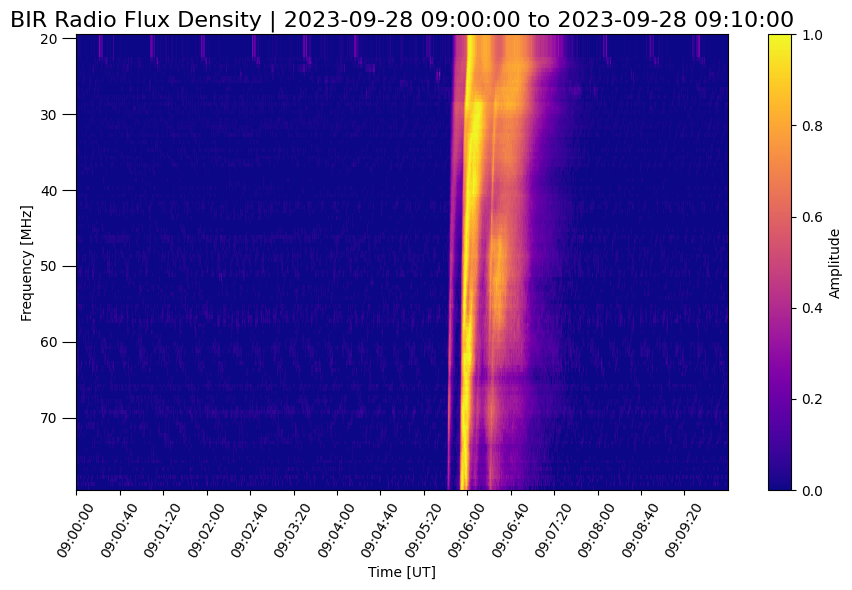

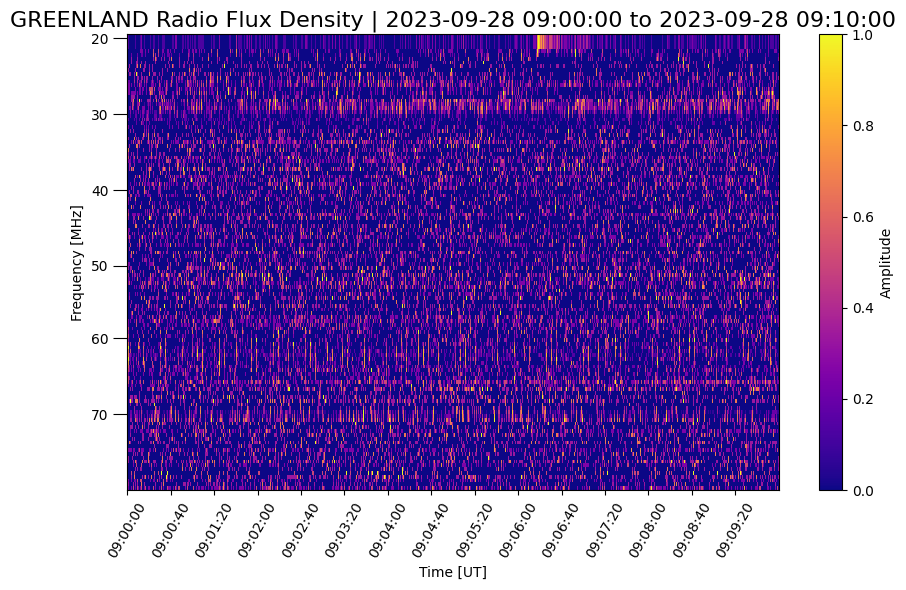

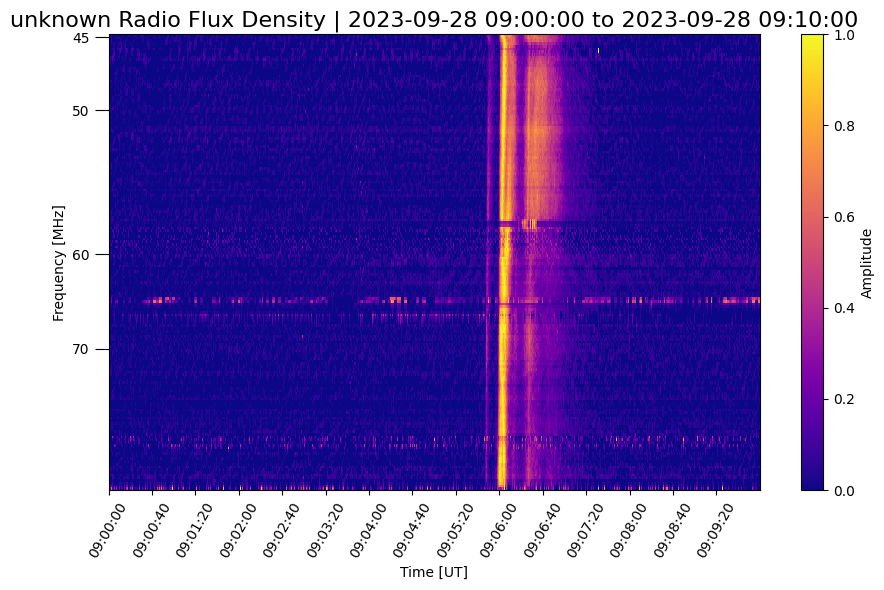

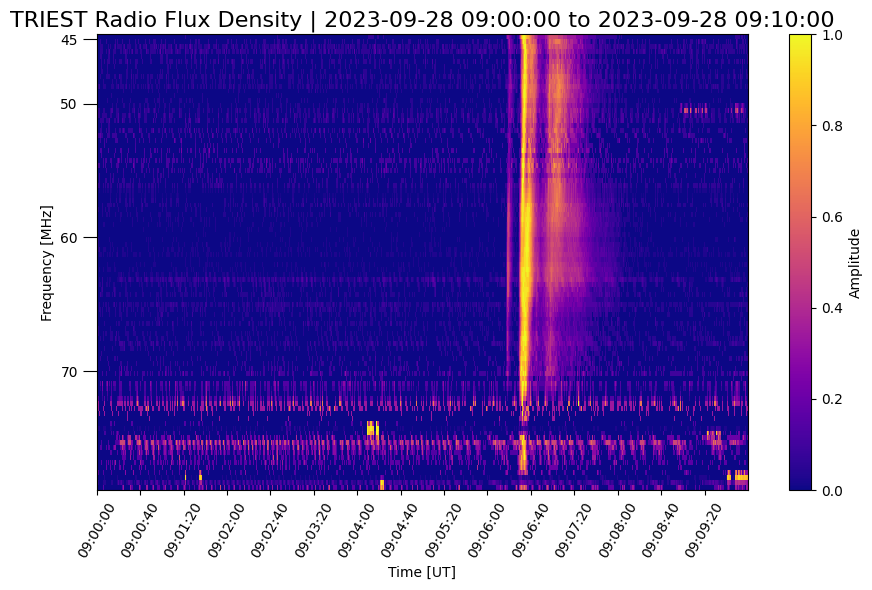

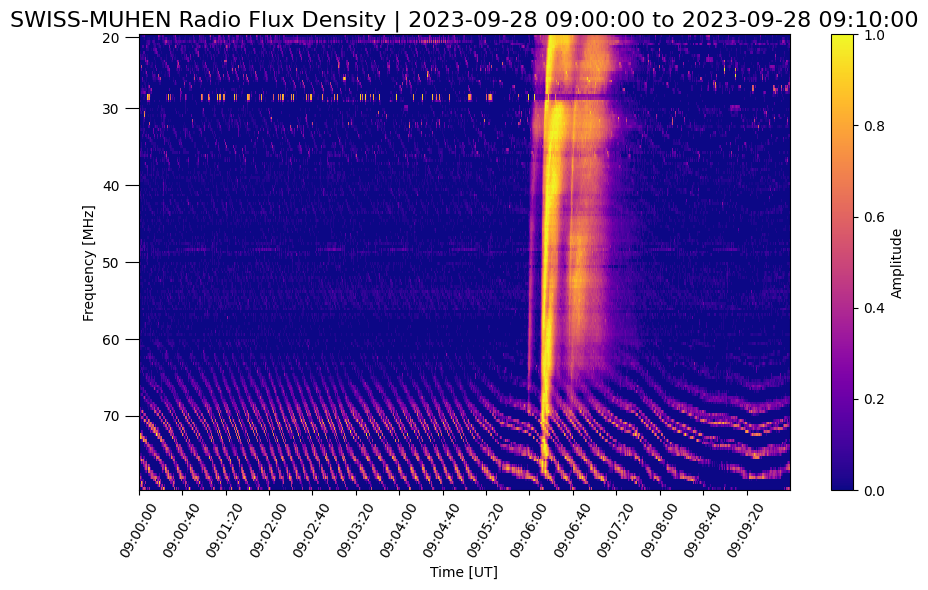

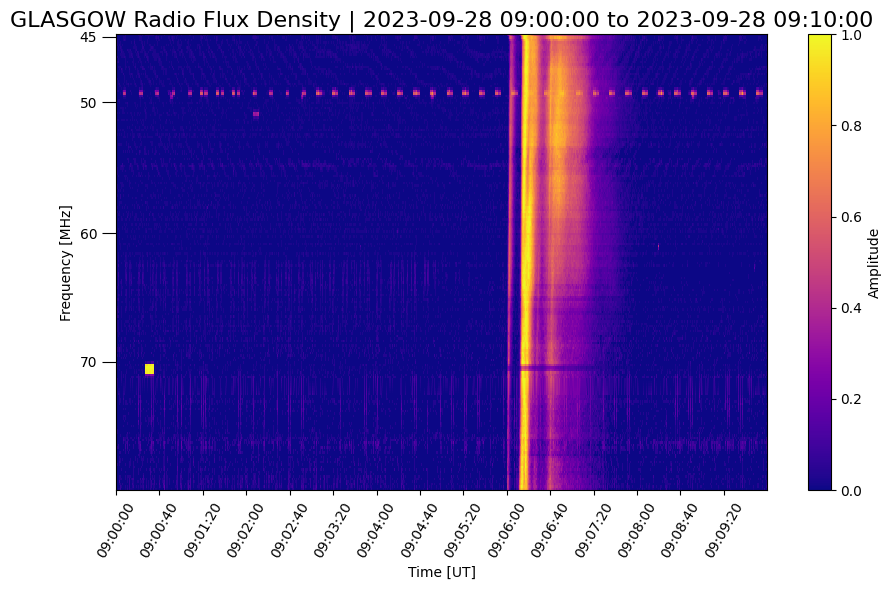

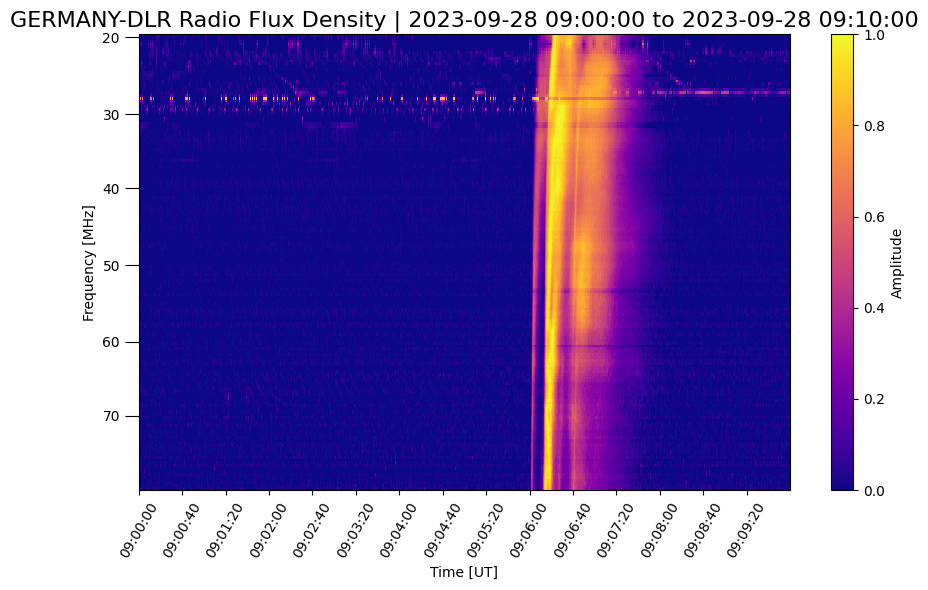

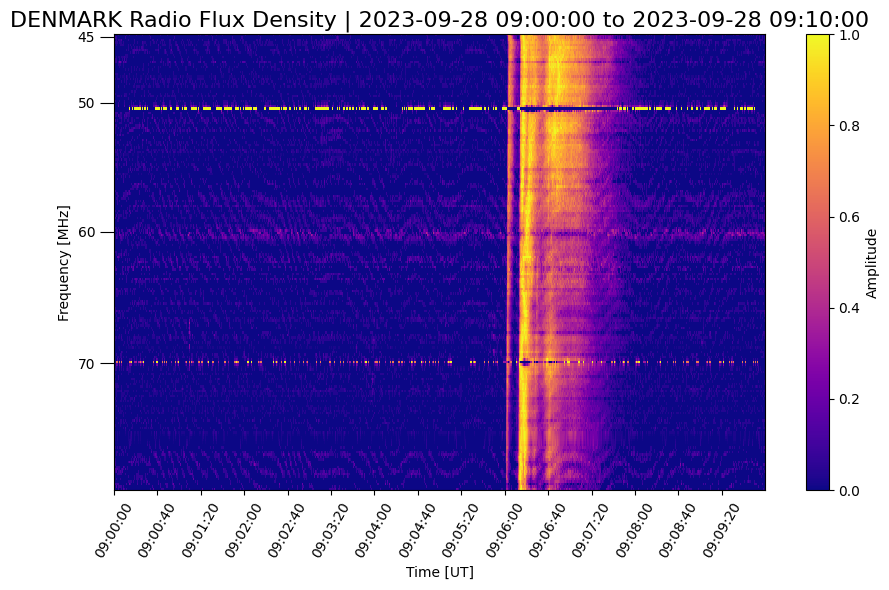

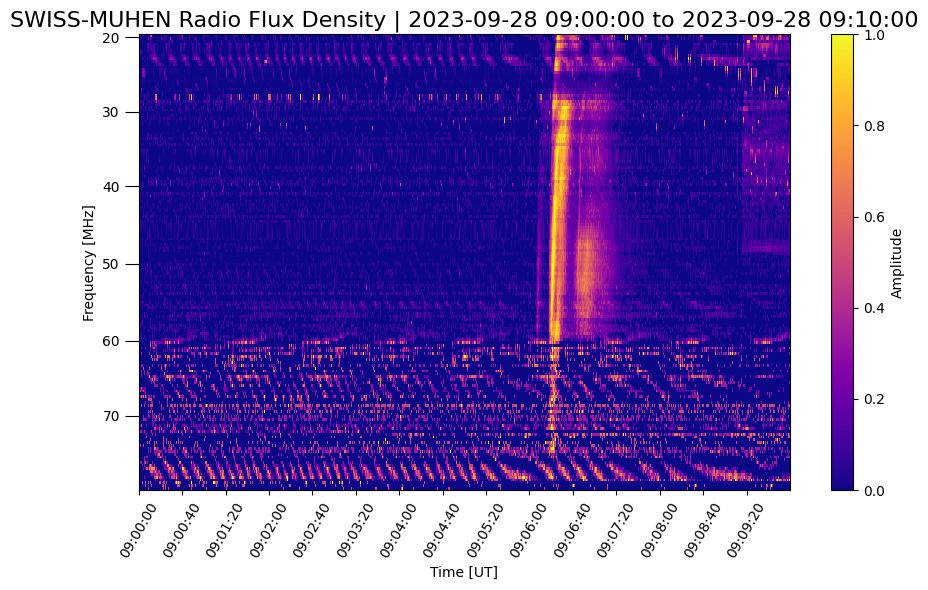

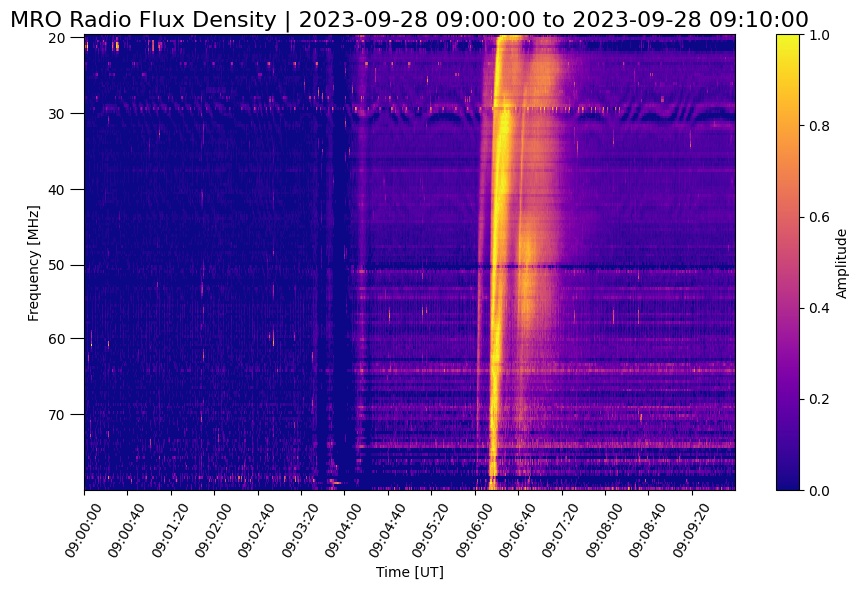

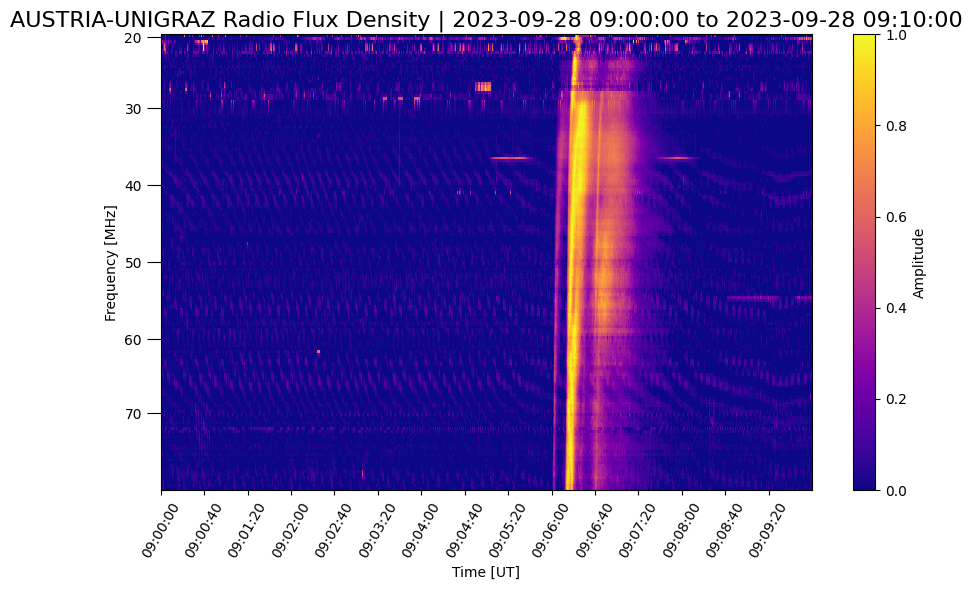

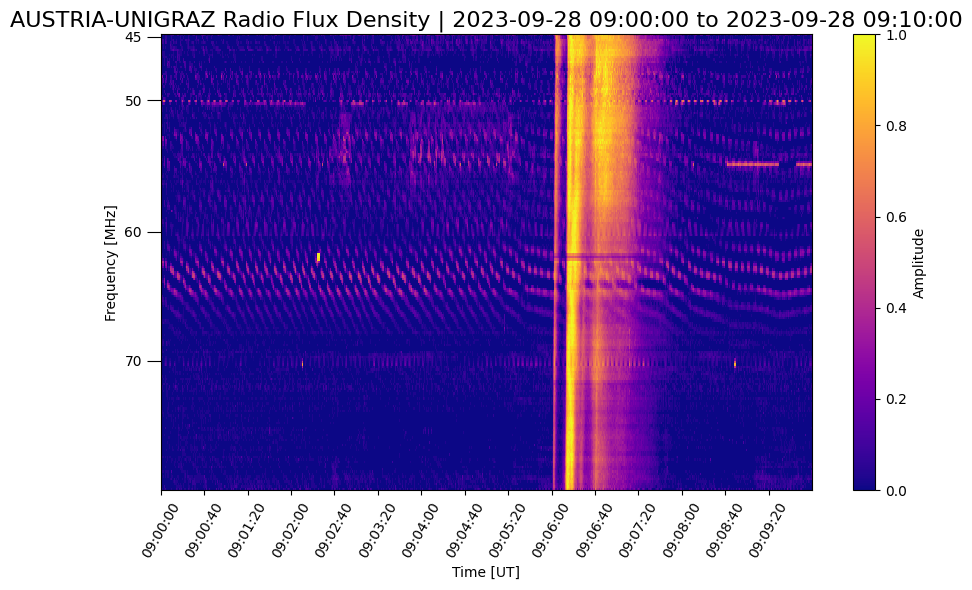

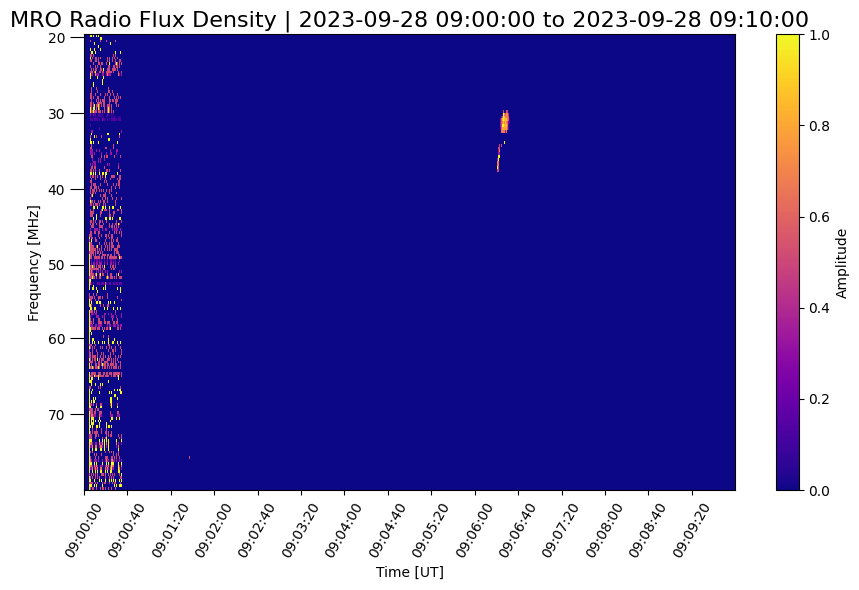

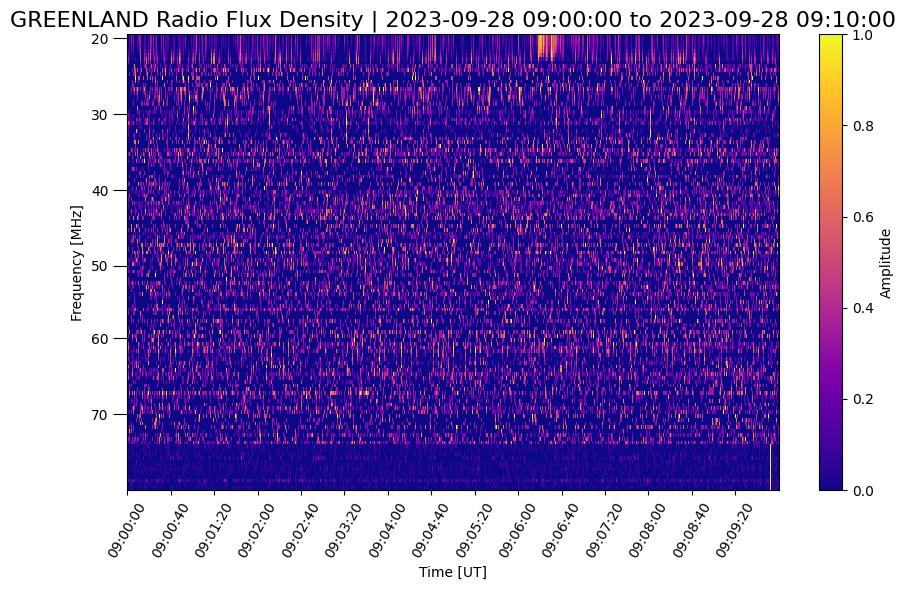

In [7]:
# Plot data
for data in data_processed:
    try:
        instr_name = data.attrs['INSTRUME']
    except:
        instr_name = 'unknown'
    fig = plot_spectogram_mpl(fill_missing_timesteps_with_nan(data), start_datetime=start_datetime, end_datetime=end_datetime, instrument_name=instr_name)

In [8]:
# Match data, in time and frequency
matched_data = match_spectrograms(data_processed)

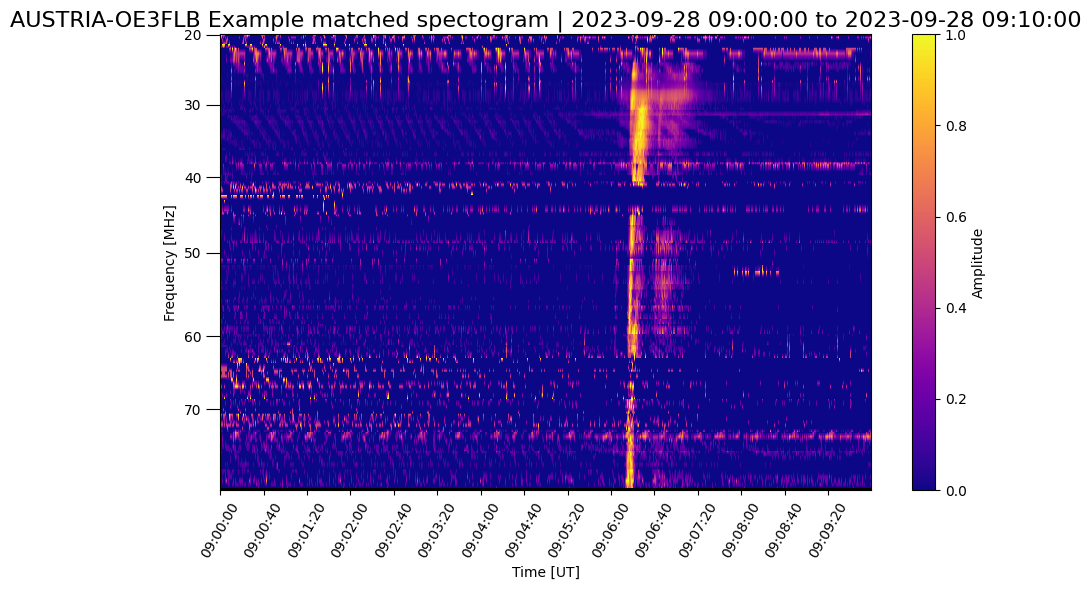

In [21]:
# Plot matched data
IDX_TO_PLOT = 3
fig = plot_spectogram_mpl(matched_data[IDX_TO_PLOT], matched_data[IDX_TO_PLOT].attrs['INSTRUME'], start_datetime, end_datetime, title='Example matched spectogram')

In [23]:
# Sync data in time (e.g. if some clocks of antennas are not synced)
synced_data, ref_idx = sync_spectrograms(matched_data)

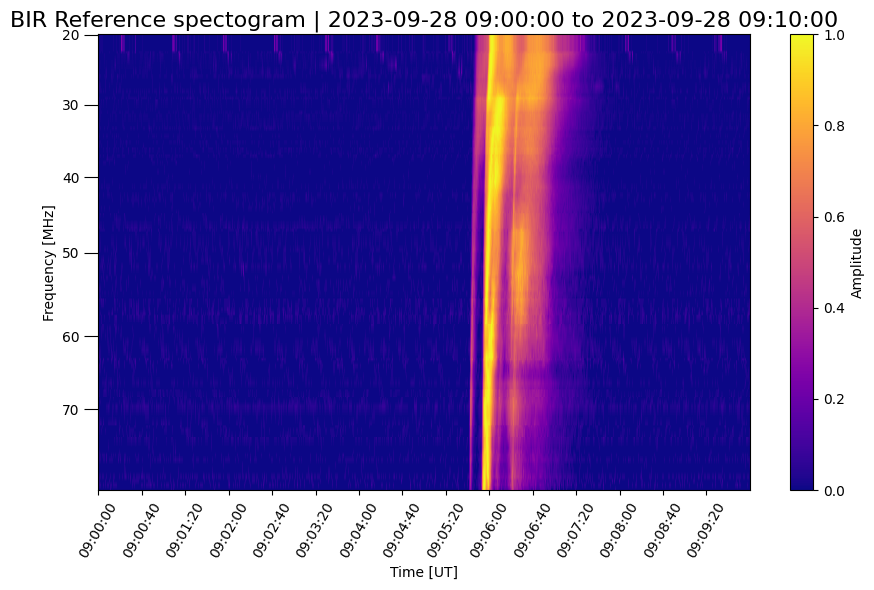

In [24]:
# Plot the spectogram, which most spectograms are in sync to
ref_spectogram_df = pd.DataFrame(synced_data[ref_idx], columns=synced_data[1].columns, index=synced_data[1].index)
fig = plot_spectogram_mpl(synced_data[ref_idx], synced_data[ref_idx].attrs['INSTRUME'], start_datetime, end_datetime, title='Reference spectogram')

In [27]:
# Correlation with reference spectogram. Maybe we can do something with this?
def correlation_with_reference(spec_list, ref_idx):
    ref_spec = np.sum(spec_list[ref_idx], axis=1)
    correlations = []
    for spec in spec_list:
        correlations.append(np.corrcoef(ref_spec, np.sum(spec, axis=1))[0, 1])
    return correlations

In [28]:
corr_w_reference = correlation_with_reference(synced_data, ref_idx)
corr_w_reference

[0.7448340569353997,
 0.7035469095609751,
 0.7288707569177322,
 0.5894732128069652,
 0.6770262485117909,
 0.6255799410061313,
 0.7779676355440548,
 1.0,
 0.07536975609880707,
 0.9041801272061258,
 0.49090647843618335,
 0.7776585247089078,
 0.735456759945133,
 0.7414330314746589,
 0.7411167978541197,
 0.656532014332832,
 0.7174710556673238,
 0.738837731390177,
 0.74885705147702,
 -0.051387409327949406,
 0.027575338486294957]

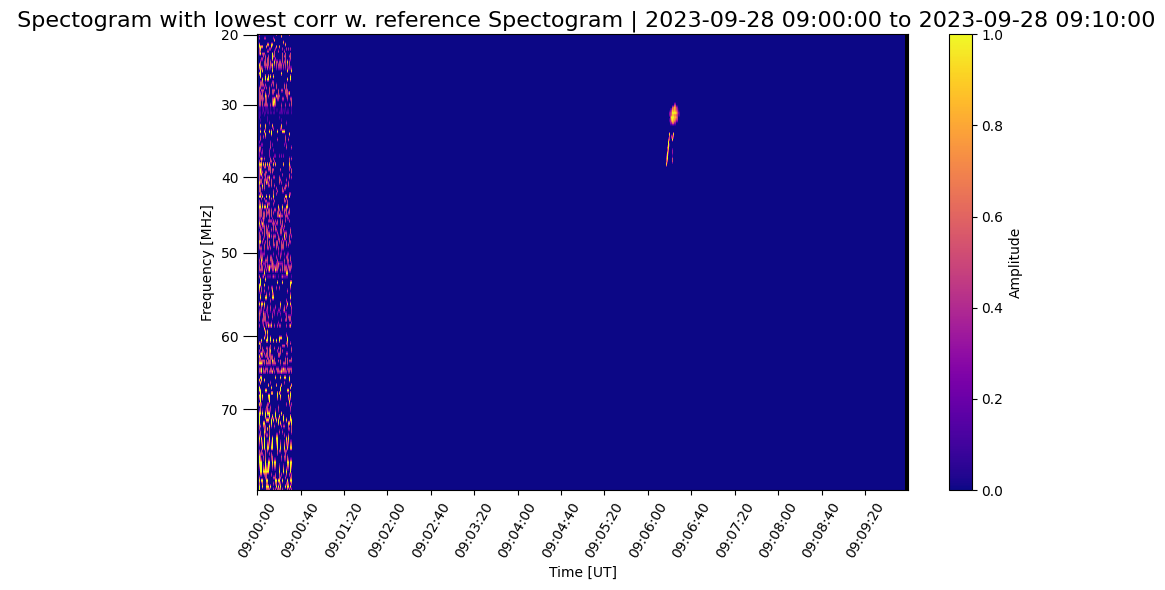

In [39]:
# Plot
fig = plot_spectogram_mpl(synced_data[np.argmin(corr_w_reference)], "", start_datetime, end_datetime, title='Spectogram with lowest corr w. reference Spectogram')

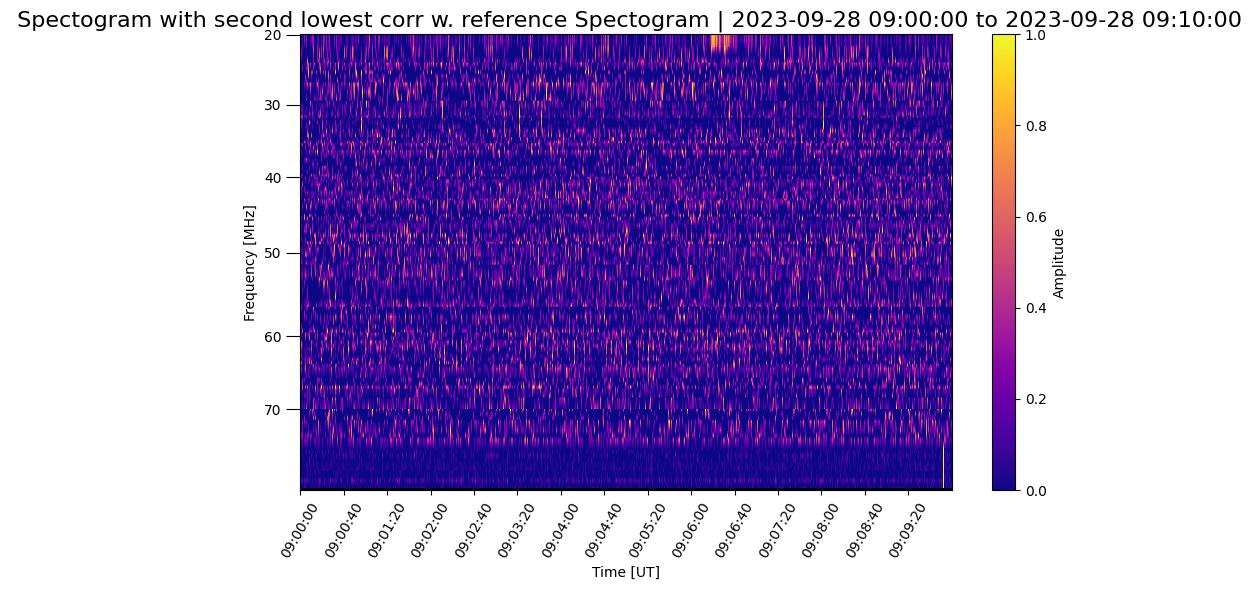

In [41]:
# Plot
fig = plot_spectogram_mpl(synced_data[-1], "", start_datetime, end_datetime, title='Spectogram with second lowest corr w. reference Spectogram')

In [35]:
# Calculate quantile of all matched and synced spectograms
QUANTILE = 0.4
##
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in synced_data])
torch_quantile = torch.nanquantile(torch_shifted, QUANTILE, dim=0)

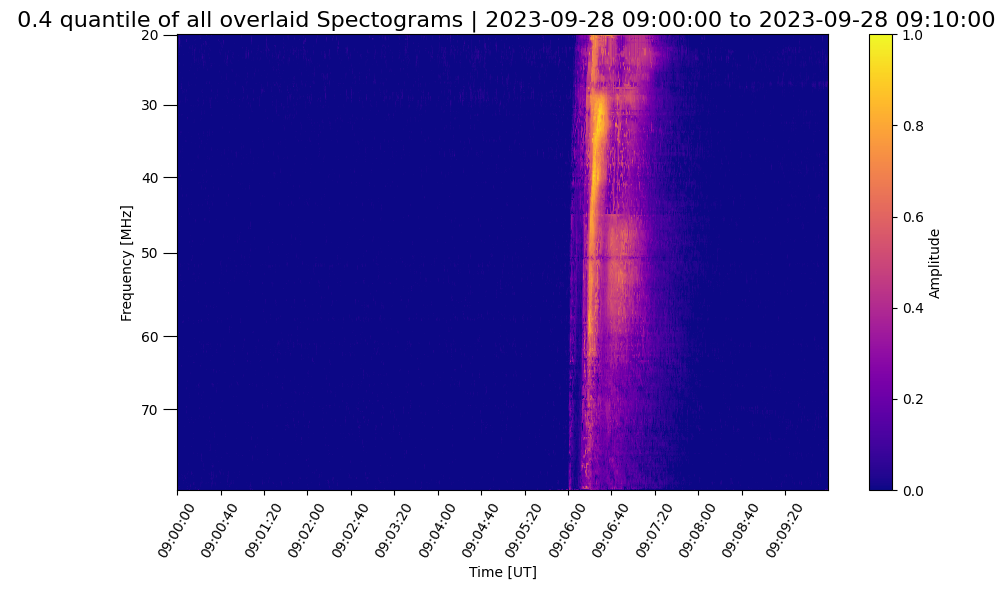

In [38]:
# Plot result
data_quantile_df = pd.DataFrame(torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index)
fig = plot_spectogram_mpl(data_quantile_df, "", start_datetime, end_datetime, title=f'{QUANTILE} quantile of all overlaid Spectograms')

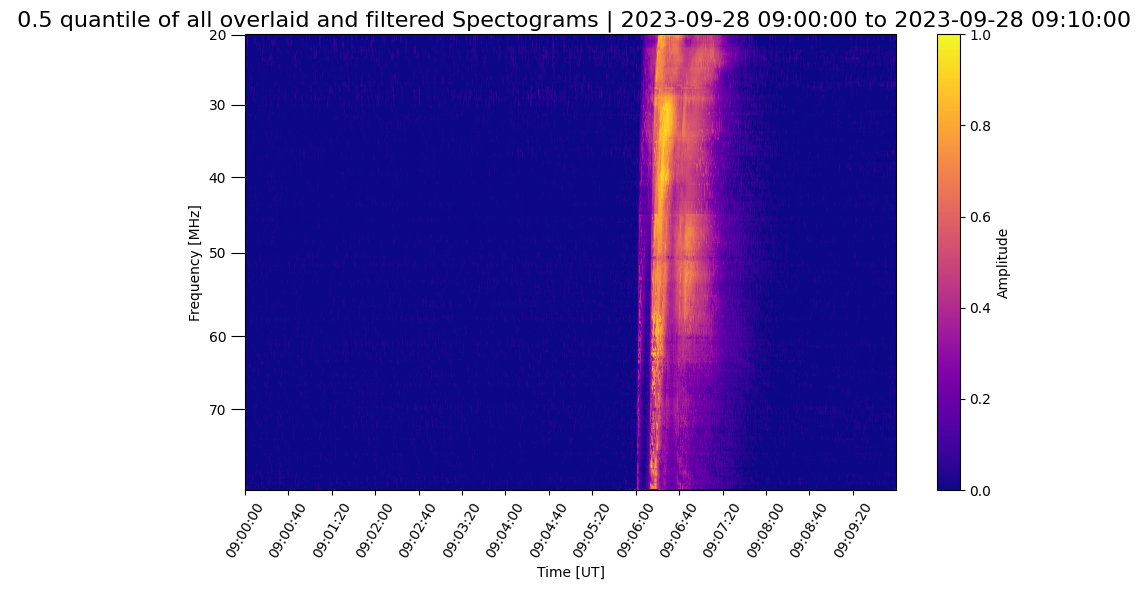

In [45]:
# Filter out all spectograms with correlation below a certain threshold
CORR_THRESHOLD = 0.3
QUANTILE = 0.5

## Filter by corr
idx_to_keep = np.where(np.array(corr_w_reference) > CORR_THRESHOLD)[0]
synced_data_filtered = [synced_data[idx] for idx in idx_to_keep]
torch_corr = torch.stack([torch.from_numpy(df.values) for df in synced_data_filtered])

# Caculate quantile
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in synced_data])
torch_quantile = torch.nanquantile(torch_shifted, QUANTILE, dim=0)

# Plot result
data_quantile_df = pd.DataFrame(torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index)
fig = plot_spectogram_mpl(data_quantile_df, "", start_datetime, end_datetime, title=f'{QUANTILE} quantile of all overlaid and filtered Spectograms')